Import data and combine z-stacks

In [2]:
from jiaoyang_analysis.config import data_dir
import numpy as np
import tifffile

print(data_dir / 'selecttest3.tif')

img = tifffile.imread(data_dir / 'selecttest3.tif')
print(img.shape) # (z, channels, y, x)
img_zproj = np.max(img, axis=0) # z-projection with maximum intensity

/Users/nathanyeelee/Documents/GitHub/jiaoyang_analysis/data/selecttest3.tif


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nathanyeelee/Documents/GitHub/jiaoyang_analysis/data/selecttest3.tif'

Import ROIs

In [91]:
roi = tifffile.imread('/Users/nathanyeelee/Documents/GitHub/JiaoyangAnalysis/Data/Mask.tif')
mask = roi > 0 # convert to binary mask

img_slice = img_zproj[0, :, :] # temporarily first channel
img_roi = np.where(mask, img_slice, 0) # apply mask to image
roi_size = np.count_nonzero(img_roi)

print(f"ROI size: {roi_size} pixels")

ROI size: 933422 pixels


Visualize data using seaborn

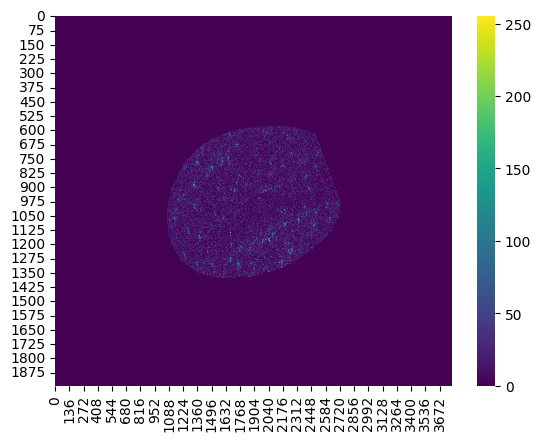

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(img_roi, square=False, cmap='viridis')
plt.show()

Detect microglia

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology

block_size = 91  # size of the local neighborhood; must be odd
offset = -0.15  # adjusts sensitivity: greater = stricter
local_thresh = filters.threshold_local(img_roi, block_size=block_size, offset=offset)
binary = img_roi > local_thresh

binary = morphology.remove_small_objects(binary, min_size=100)  # remove tiny noise
binary = morphology.remove_small_holes(binary, area_threshold=50)

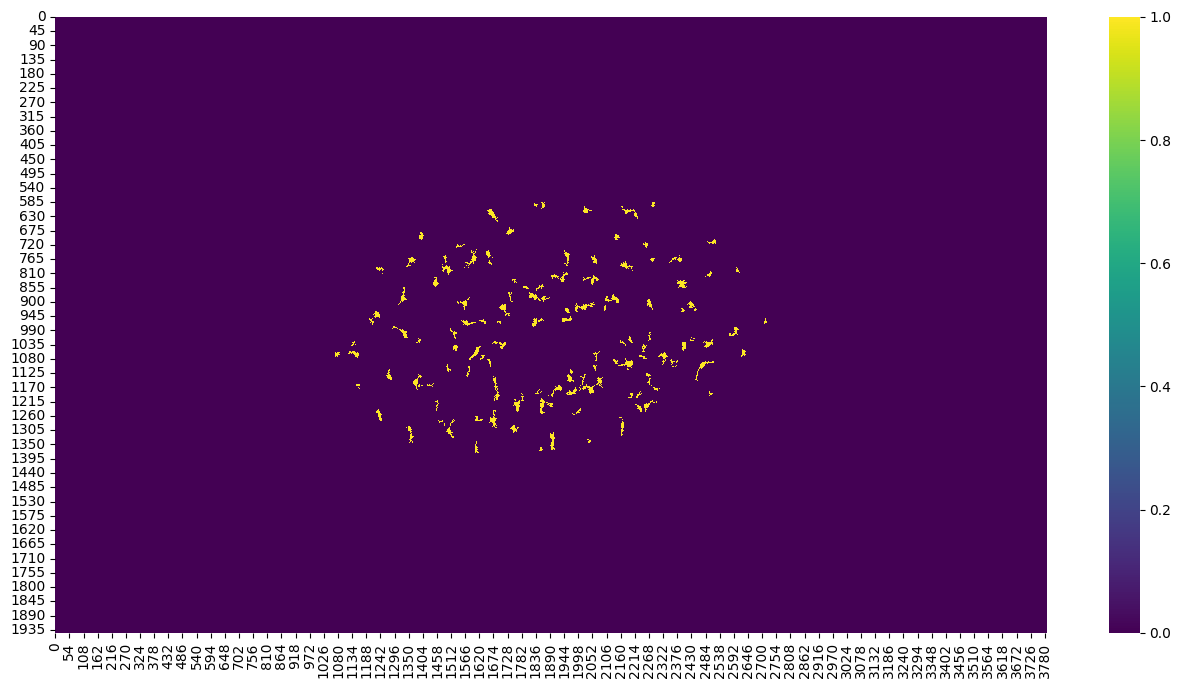

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(binary, square=False, cmap='viridis')
plt.show()

Detected 128 objects in the binary mask
89 soma-like objects detected after filtering


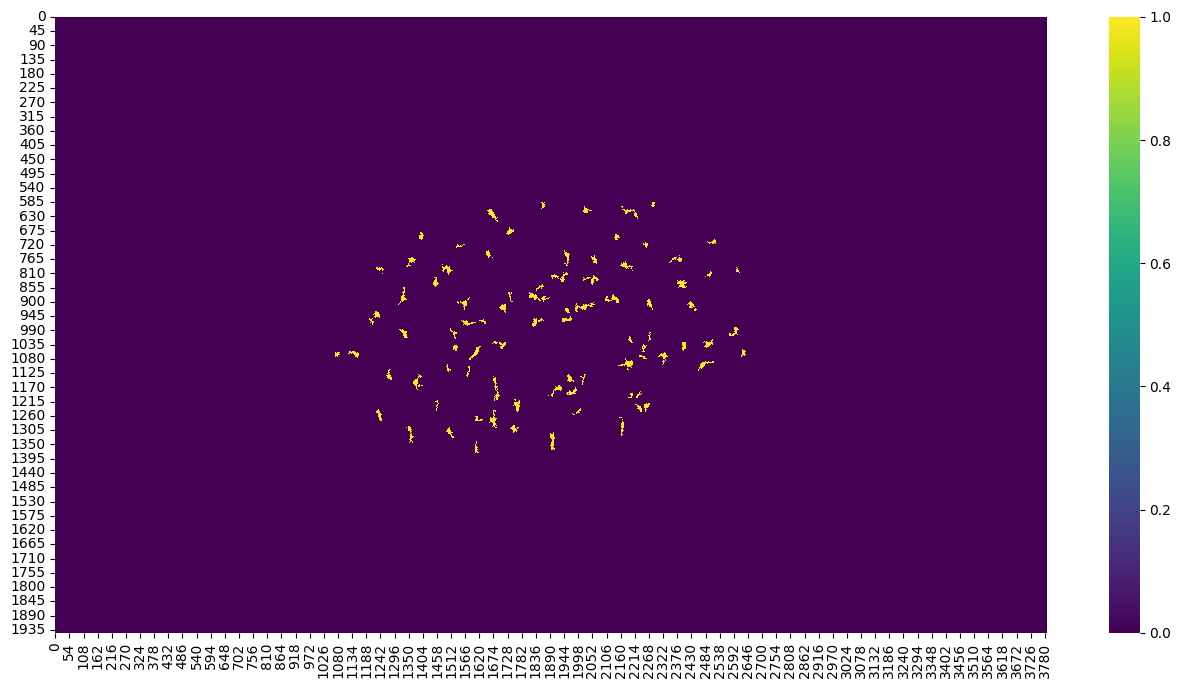

In [155]:
# Assign labels to connected components
labels = measure.label(binary)
props = measure.regionprops(labels)
print("Detected", len(props), "objects in the binary mask")

# Filter objects by shape: keep only likely soma
filtered_labels = np.zeros_like(labels)
filtered_labels_count = 0

for prop in props:
    area = prop.area
    solidity = prop.solidity          # thinness-indicator; ratio of area to convex area; near 1 = compact
    eccentricity = prop.eccentricity  # 0 = circle, close to 1 = elongated

    # Filtering criteria
    if area > 150 and solidity > 0.4:
        filtered_labels[labels == prop.label] = 1
        filtered_labels_count += 1

print(filtered_labels_count, "soma-like objects detected after filtering")

plt.figure(figsize=(16, 8))
sns.heatmap(filtered_labels, square=False, cmap='viridis')
plt.show()
